# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**


In [4]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None) # There are no headers in the data file

# Adding column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Dropping timestamp column
df = df.drop('timestamp', axis = 1)

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [5]:
# Getting the column containing the users
users = df.user_id

# Creating a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# Users having at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Getting the column containing the products
prods = df.prod_id

# Creating a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [8]:
# Items having at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [9]:
# Printing first 5 rows of the final dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [10]:
# Checking the shape of the data
df_final.shape

(65290, 3)

**Observations:** The final dataset contains 65290 rows and 3 columns.

### **Data types**

In [11]:
# Checking the datatypes of the colums in dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**

- Columns user_id and prod_id are of object type.
- The rating column is of numerical float type.

### **Checking for missing values**

In [12]:
# Checking for missing values in the data
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**
There are no missing values in all 3 columns and hence no missing values in the dataset

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**
- The 25th percentile is 4.00 which means at least 75 percent of the ratings are rated 4 and above.
- The 50th percentile is 5.00 which means at least half of the ratings are rated 5.
- The mean of the ratings is 4.29 which is high.

### **Checking the rating distribution**

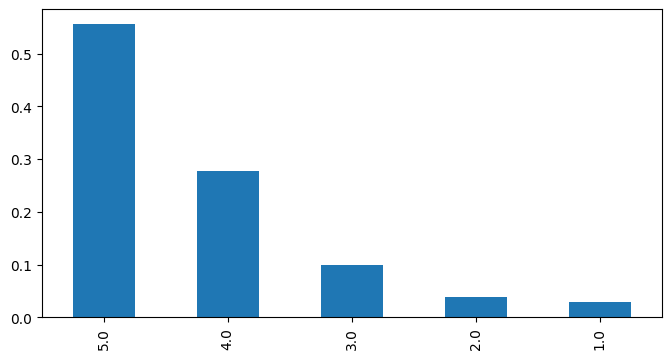

In [14]:
# Creating the bar plot for the ratings
plt.figure(figsize = (8, 4))

df_final['rating'].value_counts(1).plot(kind = 'bar')

plt.show()

**Observations:**
- The distribution is highly-skewed to the rating of 5.
- Around 55 % of the ratings are rated 5.
- Around 7 % of the ratings are rated 1 or 2. This could mean that users tend to not give rating for products they do not like

### **Checking the number of unique users and items in the dataset**

In [15]:
# Number of unique user id and product id in the data

df_final.nunique()

user_id    1540
prod_id    5689
rating        5
dtype: int64

**Observations:**
- There are 1540 unique users who have given at least 50 ratings.
- There are 5689 unique products which have at least 5 ratings

### **Users with the most number of ratings**

In [16]:
# Top 10 users based on the number of ratings
top_users = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
top_users

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

**Observations:**
- The highest number of ratings by a user is 295 which is far from the unique number of products (5689).
- As per the number of unique users and products, there is a **possibility of (1540 * 5689) =  8 761 060 ratings** in the dataset. But **we only have 65290 ratings** which means not every user has rated every product in the dataset.
- We can build a recommendation system to recommend products to users which they have not interacted with




**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [17]:
# Calculating the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculating the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Creaing a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})



In [18]:
# Sorting the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)


In [19]:
# First five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [20]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] >= min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [21]:
# Top 5 products with 50 minimum interactions
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

**Observations:** The product IDs of these top 5 products will be recommended with each product having at least 50 interactions

- 1) B001TH7GUU
- 2) B003ES5ZUU
- 3) B0019EHU8G
- 4) B006W8U2MU
- 5) B000QUUFRW

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [22]:
# Top 5 products with 100 minimum interactions
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

**Observations:** The product IDs of these top 5 products will be recommended with each product having at least 100 interactions

- 1) B003ES5ZUU
- 2) B000N99BBC
- 3) B002WE6D44
- 4) B007WTAJTO
- 5) B002V88HFE

We have recommended the **top 5** products by using the popularity recommendation system.

Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [23]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [24]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [25]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 1)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [26]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initializing the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)


# Fitting the model on the training data
sim_user_user.fit(trainset)

# computing precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Observations:**
- The RSME is 1.0260 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.862, which means out of all the relevant items, 86.2% are recommended.

- The precision is 0.844, which means out of all the recommended items, 84.4% are relevant.

- The F_1 score of the baseline model is 0.853 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [27]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the user-user-similarity-based baseline model, the predicted rating is 3.33 implying that the model is under-estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [28]:
# Finding list of user ids where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()


array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* From the above list  **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [29]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**Observations:**

- Using the user-user-similarity-based baseline model, the predicted rating is 1.99 for this user-item pair meaning user A34BZM6S9L7QI4 is unlikely to give a high rating for product 1400501466.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [30]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Finding the best RMSE score
print(gs.best_score['rmse'])

# Finding the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9723785081359261
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


**Observations:** From the grid search, the optimal values are

- k = 40
- min k = 6
- similarity measure = cosine


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [31]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Computing precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864


**Observations:**
- The RSME is 0.9759 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.896, which means out of all the relevant items, 89.6% are recommended.

- The precision is 0.834, which means out of all the recommended items, 83.4% are relevant.

- The F_1 score of the TUNED model is 0.864 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [32]:
# Using sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the user-user-similarity-based TUNED model, the predicted rating is 3.33 implying that the model is under-estimating the ratings.

In [33]:
# Using sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- Using the user-user-similarity-based TUNED model, the predicted rating is 4.30 for this user-item pair which means user A34BZM6S9L7QI4 is highly likely to give a high rating for product 1400501466

**Comparisons between BASE and TUNED models:**
- The TUNED model performed better with lower RMSE and a higher F1 score.
- BASE and TUNED models gave same predictions for a user-item pair with known rating.
- BASE and TUNED models gave different predictions for a user-item pair with unknown rating


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [34]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[1, 10, 17, 18, 28]

**Observations:**

- The 5 most similar users (to the first user in the list) have inner ids 1, 10, 17, 18 and 28

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [35]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [36]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [37]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


**Observations:** The top 5 products (all 5 products have predicted ratings of 5) which should be recommended to user A3LDPF5FMB782Z have product IDs

- B000067RT6
- B001TH7GUU
- B001UI2FPE
- B001V9KG0I
- B00316263Y

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

- Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Training the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Computing precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


**Observations:**
- The RSME is 1.0147 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.853, which means out of all the relevant items, 85.3% are recommended.

- The precision is 0.826, which means out of all the recommended items, 82.6% are relevant.

- The F_1 score of the baseline model is 0.839 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [39]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the item-item-similarity-based baseline model, the predicted rating is 4.30 which is close to the actual rating and slightly under-estimating the rating.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [40]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**

- Using the item-item-similarity-based baseline model, the predicted rating is 4.00 for this user-item pair which means user A34BZM6S9L7QI4 is highly likely to give a high rating for product 1400501466

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [41]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)


# Finding the best RMSE score
print(gs.best_score['rmse'])

# Finding the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9751488244804194
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


**Observations:** From the grid search, the optimal values are

- k = 30
- min k = 6
- similarity measure = msd

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [42]:
# Using the optimal similarity measure for item-item based collaborative filtering

sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Computing precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


**Observations:**
- The RSME is 0.9751 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.892, which means out of all the relevant items, 89.2% are recommended.

- The precision is 0.829, which means out of all the recommended items, 82.9% are relevant.

- The F_1 score of the baseline model is 0.859 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Using sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.62   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the item-item-similarity-based TUNED model, the predicted rating is 4.62 which is very close to the actual rating and slightly under-estimating the rating.
 .

In [44]:
# Using sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- Using the item-item-similarity-based TUNED model, the predicted rating is 4.30 for this user-item pair.

**Comparisons between BASE and TUNED models:**
- The TUNED model performed better with lower RMSE and a higher F1 score.
- BASE and TUNED models gave similar predictions for a user-item pair with known rating.
- BASE and TUNED models gave similar predictions for a user-item pair with unknown rating

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [45]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[2, 4, 9, 12, 13]

**Observations:**

- The 5 most similar items (to the first item in the list) have internal ids 2, 4, 9, 12 and 13

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)


In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


**Observations:** The top 5 products (all 5 products have predicted ratings of 4.296) which should be recommended to user A1A5KUIIIHFF4U have product IDs

- 1400532655
- 1400599997
- 9983891212
- B00000DM9W
- B00000J1V5

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Let us now get into **model-based collaborative filtering algorithms**.

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the train set
svd.fit(trainset)

# Using the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


**Observations:**
- The RSME is 0.9104 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.88, which means out of all the relevant items, 88% are recommended.

- The precision is 0.837, which means out of all the recommended items, 83.7% are relevant.

- The F_1 score of the baseline model is 0.858 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [49]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the SVD baseline model, the predicted rating is 4.09 which is  close to the actual rating and slightly under-estimating the rating. .

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [50]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.05   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**Observations:**

- Using the SVD baseline model, the predicted rating is 4.05 for this user-item pair meaning user A34BZM6S9L7QI4 is highly likely to give a high rating for item 1400501466

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [51]:
# Setting the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Find the best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])


0.8987496530375852
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


**Observations:** From the grid search, the optimal values are

- n_epochs = 20
- lr_all = 0.01
- reg_all = 0.2

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [52]:
# Building the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Using the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86


**Observations:**
- The RSME is 0.9014 showing how far the overall predicted ratings are from the actual ratings.

- The recall is 0.88, which means out of all the relevant items, 88% are recommended.

- The precision is 0.841, which means out of all the recommended items, 84.1% are relevant.

- The F_1 score of the tuned model is 0.86 indicating that a high proportion of the recommended items were relevant and a high proportion of the relevant items were recommended to the user.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [53]:
# Using svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

**Observations:**
- The actual rating for this user-item pair is 5
- Using the SVD TUNED model, the predicted rating is 4.09 which is close to the actual rating and slightly under-estimating the rating.

In [54]:
# Using svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.06446285064312, details={'was_impossible': False})

**Observations:**

- Using the SVD TUNED model, the predicted rating is 4.06 for this user-item pair meaning user A34BZM6S9L7QI4 is highly likely to give a high rating for item 1400501466

**Comparisons between BASE and TUNED models:**
- The TUNED model performed better with lower RMSE and a higher F1 score.
- BASE and TUNED models gave same predictions for a user-item pair with known rating.
- BASE and TUNED models gave similar predictions for a user-item pair with unknown rating

### **Conclusion and Recommendations**

- When predicting the rating for user A34BZM6S9L7QI4 and product 1400501466, 5 out of 6 models gave predicted ratings of 4 and above. Since all the models (except for 1) gave similar rating for this user-item pair, it is safe to conclude that  there is a high chance that user A34BZM6S9L7QI4 will give product 1400501466 a minimum rating of 4.


- When predicting the rating for user A3LDPF5FMB782Z and product 1400501466, 4 out of 6 models predicted a rating of 4 and above. These 4 models predicted closer to the true rating of 5, with the item-item based TUNED model being the closest (4.62 rating) to the true rating of 5. The 2 user-user models predicted ratings (3.33) which is further from 5. It is safe to conclude that  there is a high chance that user A3LDPF5FMB782Z will give product 1400501466 a minimum rating of 4.

- The TUNED models in all 3 types of collaborative filtering performed slightly better than their BASE counterparts. The tuned models in all 3 types of collaborative filtereing gave lower RMSE values and higher F1 scores than their respective BASE model counterparts.

- When comparing between user-user based, item-item based and SVD based models, the values were simliar for RMSE, Recall, Precision and F1 score. This means that each type of model's reliability is supported by the other types.